In [2]:
from RSA import generate_rsa_keys_with_hamming_weight, rsa_encrypt, rsa_decrypt
from Crypto.Util.number import bytes_to_long, getPrime
from Crypto.Random import get_random_bytes
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats

/home/kieron/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [8]:
key_size = 16
target_hamming_weights = [2,4, 8]
keys = {}

for hw in target_hamming_weights:
    keys[hw] = generate_rsa_keys_with_hamming_weight(key_size, hw)

print(keys)

{2: ({'n': 31921, 'e': 65537}, {'n': 31921, 'd': 2049}), 4: ({'n': 26441, 'e': 65537}, {'n': 26441, 'd': 19457}), 8: ({'n': 57599, 'e': 65537}, {'n': 57599, 'd': 32513})}


In [63]:
# Assuming you have a function to convert plaintext messages to integers
# For simplicity, let's define a small utility function
def plaintext_to_integer(message_length, n):
    """
    Generate a random plaintext message as an integer.
    """
    plaintext_bytes = getPrime(message_length).to_bytes(message_length, 'big')
    plaintext_int = bytes_to_long(plaintext_bytes)
    # Ensure the plaintext is smaller than n
    return plaintext_int % n

# Collecting timing data
def collect_timing_data(keys, num_messages=100, message_length=256):
    timing_data = {}
    for hw, key_pair in keys.items():
        public_key, private_key = key_pair
        timing_data[hw] = []
        for _ in range(num_messages):
            message_bytes = get_random_bytes(message_length)  # Generate message as bytes
            message_int = bytes_to_long(message_bytes)
            ciphertext = rsa_encrypt(public_key, message_int)
            start = time.perf_counter()
            rsa_decrypt(private_key, ciphertext)
            end = time.perf_counter()
            decryption_time = end - start
            timing_data[hw].append(decryption_time)
    return timing_data

timing_results = collect_timing_data(keys)

In [64]:
# Convert the timing results to a format suitable for analysis and plotting
timings = []
weights = []
for hw, times in timing_results.items():
    timings.extend(times)  # Add all timings to the list
    weights.extend([hw] * len(times))  # Repeat the hamming weight for each timing value

# Convert to numpy arrays for easier statistical analysis
timings = np.array(timings)
weights = np.array(weights)

# Conduct basic statistical analysis
# Example: Calculate mean decryption time for each Hamming weight
unique_weights = np.unique(weights)
mean_times = {weight: np.mean(timings[weights == weight]) for weight in unique_weights}
print("Mean decryption times by Hamming weight:", mean_times)

data = pd.DataFrame({
    'Decryption Time': timings,
    'Hamming Weight': weights
})

Mean decryption times by Hamming weight: {2: 6.670588998986205e-05, 4: 8.60528499697466e-05, 8: 0.0001232706200062239}


In [65]:
# Assuming your timing_data is a dictionary where the keys are Hamming weights
# and the values are lists of decryption times

# Convert the timing data to a format that can be used with kruskal()
data_for_test = []
for hw, times in timing_results.items():
    data_for_test.append(times)

# Perform the Kruskal-Wallis H-test
stat, p = stats.kruskal(*data_for_test)

print(f'Kruskal-Wallis H-test stat: {stat}, p-value: {p}')

# Interpret the results
if p < 0.05:
    print("There is a statistically significant difference between the groups.")
else:
    print("There is no statistically significant difference between the groups.")


Kruskal-Wallis H-test stat: 261.17939762342763, p-value: 1.9302537847221033e-57
There is a statistically significant difference between the groups.


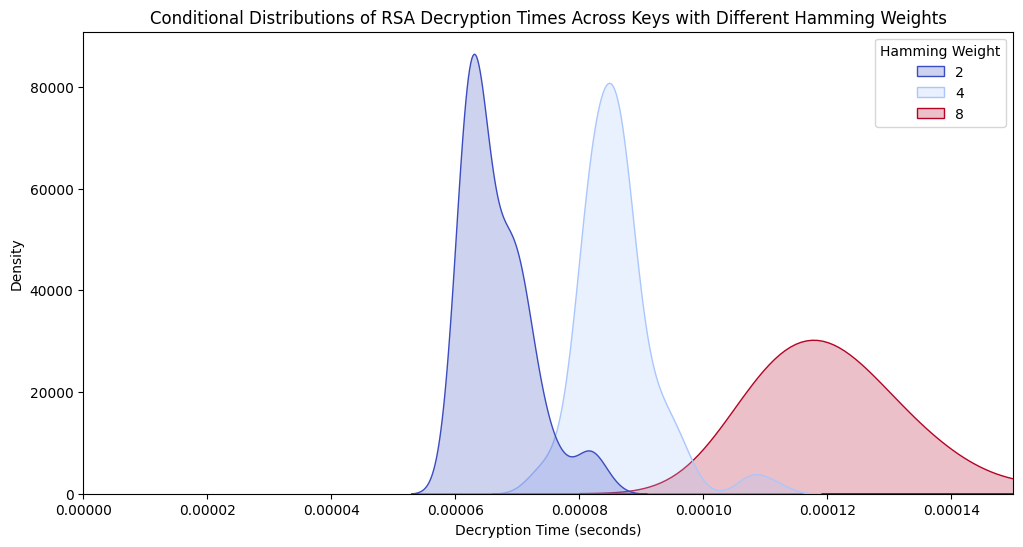

In [66]:
# Now use seaborn's kdeplot with the DataFrame
plt.figure(figsize=(12, 6))
sns.kdeplot(data=data, x='Decryption Time', hue='Hamming Weight', common_norm=False, palette="coolwarm", fill=True)
plt.title('Conditional Distributions of RSA Decryption Times Across Keys with Different Hamming Weights')
plt.xlabel('Decryption Time (seconds)')
plt.ylabel('Density')
plt.xlim(0, 0.00015)
plt.show()

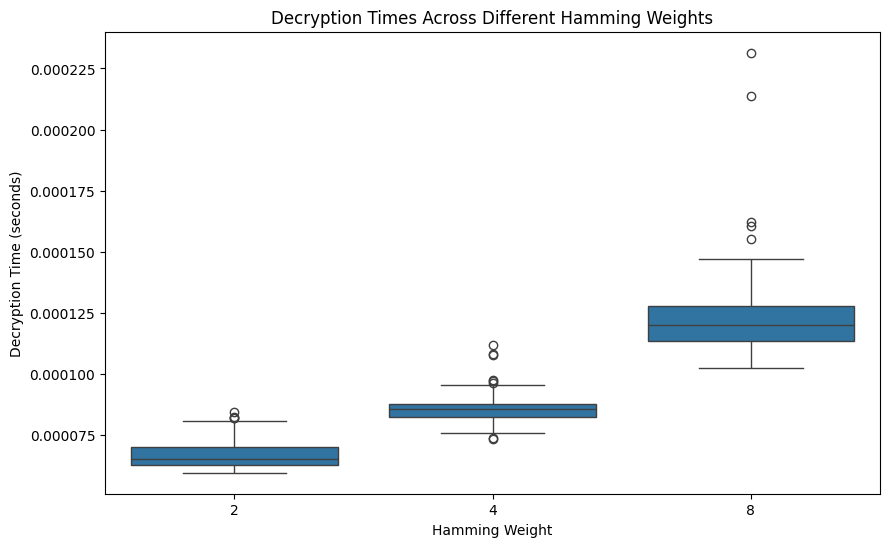

: 

In [67]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Hamming Weight', y='Decryption Time', data=data)

plt.title('Decryption Times Across Different Hamming Weights')
plt.xlabel('Hamming Weight')
plt.ylabel('Decryption Time (seconds)')

plt.show()